In [1]:
# get_ipython().magic('matplotlib notebook')
# get_ipython().magic('matplotlib inline')
# get_ipython().magic('load_ext autoreload')
# get_ipython().magic('autoreload 2')
%matplotlib inline
%load_ext autoreload
%autoreload 2
    
#___________________________________________________________________________________________________________________
import os
import tripyview as tpv
import shapefile as shp
import numpy     as np
import xarray    as xr
import time      as clock
import warnings
xr.set_options(keep_attrs=True)
do_parallel   = False
parallel_nprc = 48   # number of dask workers
parallel_tmem = 200  # max. available RAM

/albedo/home/pscholz/tripyview


### INFO:
To compute especially on large unstructured grids #vertices>1M, you need to run this notebook in parallel (do_parallel=True) on several workers (parallel_nprc...is the number of dask worker that can be allocated, parallel_tmem...is the maximum available RAM that will be distributed between the dask workers). Therefor allocate a full !!! COMPUTE NODE !!! (admins might not be happy if you do this in parallel on a login node) of a HPC of your choice with as much memory (RAM) as you can get to run this notebook!

In [2]:
if do_parallel:
    from dask.distributed import Client
    # from dask.diagnostics import ProgressBar
    import dask
    print(' --> memory_limit: {:3.3f} GB'.format(parallel_tmem/(parallel_nprc)))
    ## dask.config.config.get('distributed').get('dashboard').update({'link':'{JUPYTERHUB_SERVICE_PREFIX}/proxy/{port}/status'})
    client = Client(n_workers=parallel_nprc, threads_per_worker=1, memory_limit='{:3.3f} GB'.format(parallel_tmem/parallel_nprc))
    client

In [3]:
# Parameters
# mesh_path ='/work/ollie/projects/clidyn/FESOM2/meshes/core2/'
mesh_path = '/albedo/work/user/pscholz/mesh_fesom2.0/core2_srt_dep@node/'
# mesh_path = '/albedo/work/user/pscholz/mesh_fesom2.0/dart_test/'
save_path = None #'~/figures/test_papermill/'
save_fname= None

#_____________________________________________________________________________________
input_paths= list()
input_paths.append('/albedo/work/projects/p_fesom/pscholz/project_TRR181/trr181_tke+idemix_jayne_bin_ck0.1/5/')
input_paths.append('/albedo/work/projects/p_fesom/pscholz/project_TRR181/trr181_tke+idemix_nycander_bin_ck0.1/5/')
input_paths.append('/albedo/work/projects/p_fesom/pscholz/project_TRR181/trr181_tke+idemix_stormtide_bin_ck0.1/5/')
input_paths.append('/albedo/work/projects/p_fesom/pscholz/project_TRR181/trr181_tke_ctrl_ck0.1/5/')

input_names= list()
input_names.append('TKE+IDEMIX, jayne')
input_names.append('TKE+IDEMIX, nycander')
input_names.append('TKE+IDEMIX, stormtide')
input_names.append('TKE')

# n_cycl: which spinupcycle should be plottet if do_allcycl all spinupcycles from [1...n_cycle] are plottet, if None path is directly used
n_cycl    = None
do_allcycl= False
vname     = 'temp'
year      = [1979,2019]
mon, day, record, box, depth = None, None, None, None, None

#_____________________________________________________________________________________
# do anomaly plots in case ref_path is not None
# ref_path  = None #'/home/ollie/pscholz/results/trr181_tke_ctrl_ck0.1/' # None
# ref_name  = None #'TKE, ck=0.1' # None
# ref_year  = None # [1979,2019]
# ref_mon, ref_day, ref_record = None, None, None

#_____________________________________________________________________________________
box_region = list()
box_region.append('global')
# box_region.append('ocean_basins/Arctic_Basin.shp')
# box_region.append('ocean_basins/Eurasian_Basin.shp')
# box_region.append('ocean_basins/Atlantic_Basin.shp')
# box_region.append('mpas_region/Canada_Basin.shp')
# box_region.append('mpas_region/North_Atlantic_Ocean.shp')
# box_region.append('mpas_region/Greenland_Sea.shp')
# box_region.append('mpas_region/Irminger_Sea.shp')
# box_region.append('mpas_region/Norwegian_Sea.shp')
# box_region.append('mpas_region/Labrador_Sea.shp')
# box_region.append('mpas_region/North_Pacific_Ocean.shp')
# box_region.append('mpas_region/South_Pacific_Ocean.shp')
# box_region.append('mpas_region/Southern_Ocean.shp')
# box_region.append('mpas_region/Western_Weddell_Sea.shp')

#_____________________________________________________________________________________
which_clim= 'phc3'
clim_path = '/albedo/work/projects/p_fesom/FROM-OLLIE/FESOM2/hydrography/phc3.0/phc3.0_annual.nc'

#_____________________________________________________________________________________
cstr, cnum  = 'blue2red', 15
cref, crange, cmin, cmax, cfac, climit = None, None, None, None, None, None
chist, ctresh = True, 0.995

# ref_cstr, ref_cnum = 'wbgyr', 15
# ref_cref, ref_crange, ref_cmin, ref_cmax, ref_cfac, ref_climit = None, None, None, None, None, None
# ref_chist, ref_ctresh = True, 0.995

#_____________________________________________________________________________________
ncol              = 2      # number of pannel columns in figure
do_plt            = 'tcf'  # plot pcolor (tpc) or contourf (tcf)
plt_contb         = True   # background contour line (thin)
plt_contf         = False  # contour line of main colorbar steps 
plt_contr         = False  # contour line of reference value 
plt_contl         = False  # label contourline of main colorbar steps 
do_rescale        = None   # rescale data: None, 'log10', 'slog10', np.array(...)
do_lsm            ='fesom' # 'fesom', 'bluemarble', 'etopo', 'stock'
do_mesh, mesh_opt = False, dict({'color':'k', 'linewidth':0.10})
do_enum           = False  # do enumeration of panels
# do_reffig         = True   # plot reference fig when doing anomalies 
# do_clim           = False   # plot climatolgy values when doing absoluts
ax_title          = None
cb_label          = None
save_dpi          = 300
save_fmt          = ['png']

In [4]:
#___LOAD FESOM2 MESH___________________________________________________________________________________
mesh=tpv.load_mesh_fesom2(mesh_path, do_rot='None', focus=0, do_info=True, do_pickle=True)

#______________________________________________________________________________________________________
if (n_cycl is not None): 
    cycl_s=1 if do_allcycl else n_cycl
    #__________________________________________________________________________________________________
    aux_path, aux_name = list(), list()
    input_paths_old, input_names_old = input_paths, input_names
    for ii, (ipath,iname) in enumerate(zip(input_paths,input_names)):
        for ii_cycl in range(cycl_s, n_cycl+1):
            aux_path.append(os.path.join(ipath,'{:d}/'.format(ii_cycl)))
            if not do_allcycl: aux_name.append('{}'.format(iname))
            else             : aux_name.append('{:d}) {}'.format(ii_cycl, iname))
            print(ii, aux_path[-1],aux_name[-1])
    input_paths, input_names = aux_path, aux_name
    
#     #__________________________________________________________________________________________________
#     if (ref_path is not None): 
#         aux_path, aux_name = list(), list()
#         ref_path_old, ref_name_old = ref_path, ref_name
#         for ii_cycl in range(cycl_s, n_cycl+1):
#             aux_path.append(os.path.join(ref_path,'{:d}/'.format(ii_cycl)))
#             if not do_allcycl: aux_name.append('{}'.format(ref_name))
#             else             : aux_name.append('{:d}) {}'.format(ii_cycl, ref_name))
#             print('R', ref_path[-1])        
#         ref_path, ref_name = aux_path, aux_name
#     del(aux_path, aux_name)    

#______________________________________________________________________________________________________        
cinfo=tpv.set_cinfo(cstr, cnum, crange, cmin, cmax, cref, cfac, climit, chist, ctresh)
    
#______________________________________________________________________________________________________
# # in case of diff plots
# if (ref_path is not None) and (ref_path is not "None"): 
#     if ref_year   is None: ref_year   = year
#     if ref_mon    is None: ref_mon    = mon
#     if ref_record is None: ref_record = record

#______________________________________________________________________________________________________    
# # concatenate list = list1+list2
# if (ref_path is not None) and (ref_path is not "None"): 
#     if isinstance(ref_path, list): 
#         input_paths, input_names = ref_path + input_paths, ref_name + input_names
#     else:    
#         input_paths, input_names = list([ref_path]) + input_paths, list([ref_name]) + input_names     

#________________________________________________________________________________________________________
# define index regions --> reading shape files
box = list()
shp_path = os.path.join(tpv.__path__[0],'shapefiles/')
for region in box_region:
    if region == 'global' or isinstance(region,list): box.append(region)
    else: box.append(shp.Reader(os.path.join(shp_path,region)))       

 > found *.pckl file: /albedo/work/user/pscholz/mesh_fesom2.0/core2_srt_dep@node
 > load  *.pckl file: tripyview_fesom2_core2_srt_dep@node_focus0.pckl
___FESOM2 MESH INFO________________________
 > path            = /albedo/work/user/pscholz/mesh_fesom2.0/core2_srt_dep@node
 > id              = core2_srt_dep@node
 > do rot          = None
 > [al,be,ga]      = 50, 15, -90
 > do augmpbnd     = True
 > do cavity       = False
 > do lsmask       = True
 > do earea,eresol = True, False
 > do narea,nresol = True, False
___________________________________________
 > #node           = 126858
 > #elem           = 244659
 > #lvls           = 48
___________________________________________


In [5]:
#___LOAD CLIMATOLOGY_____________________________________________________________________________________
clim_vname= vname
if vname in ['temp', 'salt', 'pdens'] or 'sigma' in vname: 
    ts = clock.time()
    if   vname=='temp' and  which_clim.lower()=='woa18': clim_vname = 't00an1'
    elif vname=='salt' and  which_clim.lower()=='woa18': clim_vname = 's00an1'
    clim        = tpv.load_climatology(mesh, clim_path, clim_vname)
    print(' --> elasped time to load clim: {:3.2f} min.'.format( (clock.time()-ts)/60  ))        
    print(' --> data uses {:3.2f} Gb:'.format(clim.nbytes/(1024**3)))
    print('')

    ts = clock.time()
    zmsect_clim = tpv.load_zmeantransect_fesom2(mesh, clim, box, diagpath=input_paths[0], do_checkbasin=False)
    print(' --> elasped time to comp. zmsect_clim: {:3.2f} sec.'.format( (clock.time()-ts)  ))   
    for ii, data_ii in enumerate(zmsect_clim):
        print(' --> zmsect[{:s}] uses {:3.2f} Mb:'.format(zmsect_clim[ii][list(zmsect_clim[ii].keys())[0]].attrs['transect_name'], zmsect_clim[ii].nbytes/(1024**2)))
    print('') 
    del(clim)
else: raise ValueError('climatology not supported for choosen vname')        


#___LOAD FESOM2 DATA____________________________________________________________________________________
data_list = list()
for datapath, descript in zip(input_paths, input_names):
    print(datapath, descript)
    ts = clock.time()
    #__________________________________________________________________________________________________
    # load data
    data            = tpv.load_data_fesom2(mesh, datapath, vname=vname, year=year, mon=mon, descript=descript, do_info=False, do_zarithm=None)
    print(' --> elasped time to load data: {:3.2f} min.'.format( (clock.time()-ts)/60  ))        
    print(' --> data uses {:3.2f} Gb:'.format(data.nbytes/(1024**3)))
    print('')
    
    #__________________________________________________________________________________________________    
    # check if data where loaded
    if data is None: raise ValueError(f'data == None, data could not be readed, your path:{datapath} might be wrong!!!')
    
    #__________________________________________________________________________________________________
    # create zonal mean data 
    ts = clock.time()
    zmsect = tpv.load_zmeantransect_fesom2(mesh, data, box, do_compute=True)
    print(' --> elasped time to comp. zmsect: {:3.2f} sec.'.format( (clock.time()-ts)  ))   
    for ii, data_ii in enumerate(zmsect):
        print(' --> zmsect[{:s}] uses {:3.2f} Mb:'.format(zmsect[ii][list(zmsect[ii].keys())[0]].attrs['transect_name'], zmsect[ii].nbytes/(1024**2)))
    print('')
    del(data)

    #__________________________________________________________________________________________________
    # create zonal anomalous data 
    zmsect = tpv.do_transect_anomaly(zmsect, zmsect_clim)
    data_list.append(zmsect)
    del(zmsect)    
del(zmsect_clim)        

 --> elasped time to load clim: 0.02 min.
 --> data uses 0.05 Gb:

 --> elasped time to comp. zmsect_clim: 0.79 sec.
 --> zmsect[global zonal mean] uses 0.06 Mb:

/albedo/work/projects/p_fesom/pscholz/project_TRR181/trr181_tke+idemix_jayne_bin_ck0.1/5/ TKE+IDEMIX, jayne
 --> elasped time to load data: 0.12 min.
 --> data uses 0.05 Gb:

 --> elasped time to comp. zmsect: 0.75 sec.
 --> zmsect[global zonal mean] uses 0.06 Mb:

/albedo/work/projects/p_fesom/pscholz/project_TRR181/trr181_tke+idemix_nycander_bin_ck0.1/5/ TKE+IDEMIX, nycander
 --> elasped time to load data: 0.14 min.
 --> data uses 0.05 Gb:

 --> elasped time to comp. zmsect: 0.78 sec.
 --> zmsect[global zonal mean] uses 0.06 Mb:

/albedo/work/projects/p_fesom/pscholz/project_TRR181/trr181_tke+idemix_stormtide_bin_ck0.1/5/ TKE+IDEMIX, stormtide
 --> elasped time to load data: 0.10 min.
 --> data uses 0.05 Gb:

 --> elasped time to comp. zmsect: 0.76 sec.
 --> zmsect[global zonal mean] uses 0.06 Mb:

/albedo/work/projects/p_f

--> histo: cmin, cmax =  -1.583847999572754 2.1145379543304443
--> histo: cmin, cmax =  -1.583847999572754 2.14581298828125
--> histo: cmin, cmax =  -1.583847999572754 2.176389217376709
--> histo: cmin, cmax =  -1.797253131866455 2.207515001296997
{'cstr': 'blue2red', 'cnum': 15, 'chist': True, 'ctresh': 0.995, 'cnlab': 8, 'cmin': -1.8, 'cmax': 2.21, 'cref': 0.2, 'cmap': <matplotlib.colors.ListedColormap object at 0x155551792160>, 'clevel': array([-1.8 , -1.55, -1.3 , -1.05, -0.8 , -0.55, -0.3 , -0.05,  0.2 ,
        0.45,  0.7 ,  0.95,  1.2 ,  1.45,  1.7 ,  1.95,  2.2 ,  2.45]), 'clab': array([-1.3 , -0.55,  0.2 ,  0.95,  1.7 ,  2.45])}


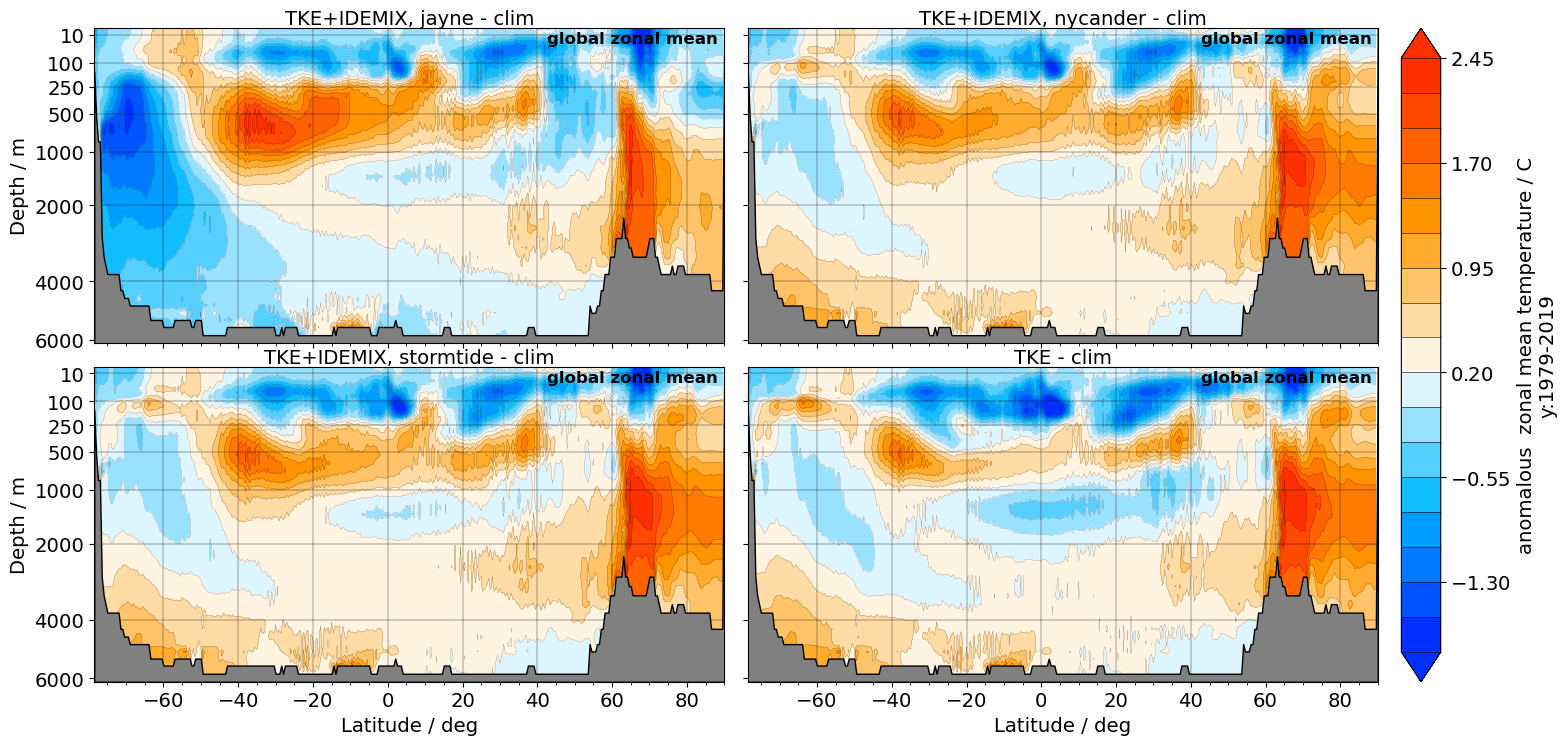

In [6]:
#___PLOT ZONMEAN TRANSECT______________________________________________________________________________
spath  = save_path
ncol0  = np.min([ncol,len(data_list)])    
nrow0  = np.ceil(len(data_list)/ncol0).astype('int')
nbox, ndat = len(box), len(data_list)
for box_idx in range(nbox):
    svname = list(data_list[0][box_idx].data_vars)[0]
    slabel = data_list[0][box_idx][svname].attrs['str_lsave']
    stname = data_list[0][box_idx][svname].attrs['transect_name'].replace(' ','_').lower()
    #__________________________________________________________________________________________________
    # do save filename path
    sfpath = None
    if spath!=None: 
        sfpath=list()
        for sfmt in save_fmt: sfpath.append( os.path.join(spath,'{:s}_{:s}_{:s}_{:s}.{:s}'.format(svname, 'zonmeanclim', stname ,slabel, sfmt)) )
    
    #__________________________________________________________________________________________________
    # do colorbar either single cbar or ref_cbar + anom_cbar
    cb_plt, cb_plt_single, cinfo0 = True, True, cinfo.copy() 
    
    #__________________________________________________________________________________________________    
    hfig, hax, hcb = tpv.plot_vslice(mesh, data_list, nrow=nrow0, ncol=ncol0, box_idx=box_idx, 
                                     cinfo=cinfo0, 
                                     do_plt=do_plt, plt_contb=plt_contb, plt_contf=plt_contf, plt_contr=plt_contr, plt_contl=plt_contl, do_enum=do_enum, 
                                     ax_opt=dict({'fig_sizefac':2.0, 'cb_plt':cb_plt, 'cb_plt_single':cb_plt_single, 'cb_pos':'vertical', 'cb_h':'auto',}), # 'fs_label':14, 'fs_ticks':14, 'ax_dt':1.0}),
                                     cbl_opt=dict(), cb_label=cb_label, cbtl_opt=dict(),
                                     do_save=sfpath, save_dpi=save_dpi )    